<h1><center>The Ultimate Inc. Data Science Challenge</center></h1>

In [168]:
import numpy as np
import pandas as pd
from pandas import datetime
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import seaborn as sns

import json
from pandas.io.json import json_normalize

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.feature_extraction import DictVectorizer
from sklearn import metrics, preprocessing
import xgboost as xgb
from sklearn.svm import SVC

%matplotlib inline

# Part   1   ‑   Exploratory   data   analysis 

The   attached    logins.json    file   contains   (simulated)   timestamps   of   user   logins   in   a   particular  geographic   location.  A ggregate   these   login   counts   based   on   15­ minute   time   intervals,   and  visualize   and   describe   the   resulting   time   series   of   login   counts   in   ways   that   best   characterize   the  underlying   patterns   of   the   demand.   Please   report/illustrate   important   features   of   the   demand,  such   as   daily   cycles.   If  t here   are   data   quality   issues,   please   report   them.  

In [47]:
# load in as string to see the data structure
json.load((open('logins.json')))

{'login_time': ['1970-01-01 20:13:18',
  '1970-01-01 20:16:10',
  '1970-01-01 20:16:37',
  '1970-01-01 20:16:36',
  '1970-01-01 20:26:21',
  '1970-01-01 20:21:41',
  '1970-01-01 20:12:16',
  '1970-01-01 20:35:47',
  '1970-01-01 20:35:38',
  '1970-01-01 20:47:52',
  '1970-01-01 20:26:05',
  '1970-01-01 20:31:03',
  '1970-01-01 20:34:46',
  '1970-01-01 20:36:34',
  '1970-01-01 20:39:25',
  '1970-01-01 20:40:37',
  '1970-01-01 20:34:58',
  '1970-01-01 20:43:59',
  '1970-01-01 20:47:46',
  '1970-01-01 20:46:34',
  '1970-01-01 20:56:07',
  '1970-01-01 20:49:12',
  '1970-01-01 20:59:06',
  '1970-01-01 20:59:59',
  '1970-01-01 21:15:01',
  '1970-01-01 21:09:24',
  '1970-01-01 21:19:24',
  '1970-01-01 21:20:53',
  '1970-01-01 21:29:19',
  '1970-01-01 21:58:05',
  '1970-01-01 21:51:51',
  '1970-01-01 21:59:40',
  '1970-01-01 22:08:34',
  '1970-01-01 22:02:51',
  '1970-01-01 21:58:32',
  '1970-01-01 22:02:31',
  '1970-01-01 22:05:32',
  '1970-01-01 22:02:46',
  '1970-01-01 22:10:28',
  '1970-01-

In [48]:
# load in to a dataframe
logins_df = pd.read_json('logins.json')
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [49]:
print('data type\t',logins_df.dtypes)
print('sample size\t\t\t',len(logins_df))
print('time min\t\t',logins_df.login_time.min())
print('time max\t',logins_df.login_time.max())

data type	 login_time    datetime64[ns]
dtype: object
sample size			 93142
time min		 1970-01-01 20:12:16
time max	 1970-04-13 18:57:38


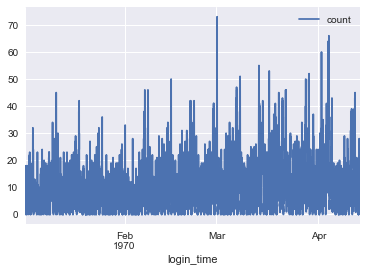

In [50]:
login=pd.DataFrame(index=logins_df['login_time']).sort_index()
login['count']=1
login=login.resample('15T').count()
login.plot()

In [51]:
login['Minute']=login.index.minute
login['Hour']=login.index.hour
login['Day']=login.index.day
login['Weekday']=login.index.weekday
login['Week']=login.index.week
login['Month']=login.index.month
login['Date']=login.index.date
login['Time']=login.index.time
login.head()

,count,Minute,Hour,Day,Weekday,Week,Month,Date,Time
login_time,,,,,,,,,
1970-01-01 20:00:00,2,0,20,1,3,1,1,1970-01-01,20:00:00
1970-01-01 20:15:00,6,15,20,1,3,1,1,1970-01-01,20:15:00
1970-01-01 20:30:00,9,30,20,1,3,1,1,1970-01-01,20:30:00
1970-01-01 20:45:00,7,45,20,1,3,1,1,1970-01-01,20:45:00
1970-01-01 21:00:00,1,0,21,1,3,1,1,1970-01-01,21:00:00


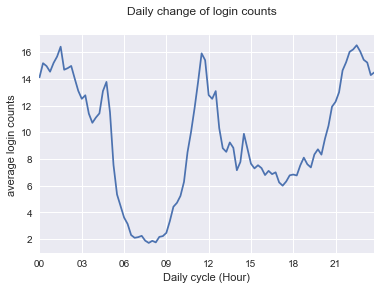

In [52]:
# daily
daily=login.groupby('Time')['count'].agg('mean')

fig, ax = plt.subplots()

daily.plot()
ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(3600*3))
fig.canvas.draw() # in order to get labels from below, otherwise won't locate x tick labels
labels = [item.get_text()[:2] for item in ax.get_xticklabels()]
ax.set_xticklabels(labels)
ax.set_xlabel('Daily cycle (Hour)')
ax.set_ylabel('average login counts')
plt.suptitle('Daily change of login counts')

The daily pattern shows that people are mostly active at night between 9pm to 4am and around noon between 10am to 2pm. The lowest active time is in the morning before 9am.

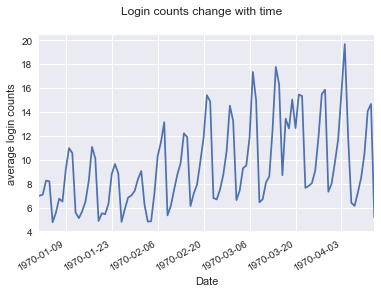

In [53]:
# trend after aggregating daily data
daily=login.groupby('Date')['count'].agg('mean')

fig, ax = plt.subplots()

daily.plot()
ax.set_xlabel('Date')
ax.set_ylabel('average login counts')
plt.suptitle('Login counts change with time')
fig.autofmt_xdate()

Weekly change seems to be the most obvious pattern

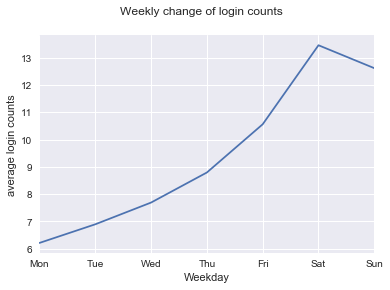

In [54]:
# weekly pattern
daily=login.groupby('Weekday')['count'].agg('mean')
weekdays=['Mon','Tue','Wed','Thu','Fri','Sat','Sun']

fig, ax = plt.subplots()

daily.plot()
ax.set_xticklabels(weekdays)
ax.set_xlabel('Weekday')
ax.set_ylabel('average login counts')
plt.suptitle('Weekly change of login counts')

The weekly pattern shows that people are least active on Monday and get more active towards the end of the week, and peaked at Saturday.

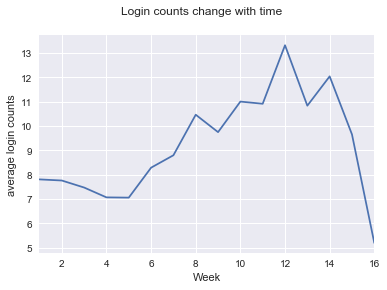

In [55]:
# trend after aggregating daily data

daily=login.groupby('Week')['count'].agg('mean')

fig, ax = plt.subplots()

daily.plot()
ax.set_xlabel('Week')
ax.set_ylabel('average login counts')
plt.suptitle('Login counts change with time')

Increase gradually first for the first three months, then start decrease sharply in the last month

# Part   2   ‑   Experiment   and   metrics  design 

The   neighboring   cities  o f   Gotham   and   Metropolis   have   complementary   circadian   rhythms:   on  weekdays,   Ultimate   Gotham   is   most   active   at   night,   and   Ultimate   Metropolis   is   most   active  during   the   day.   On   weekends,   there   is   reasonable   activity  i n   both   cities.    However,   a   toll   bridge,   with   a   two ­way   toll,   between   the   two   cities   causes   driver   partners   to   tend  to   be   exclusive   to   each   city.   The   Ultimate   managers   of   city   operations   for   the   two   cities   have  proposed   an   experiment   to   encourage   driver   partners   to   be   available   in   both   cities,   by  reimbursing   all   toll   costs. 

1. What   would   you   choose   as   the   key   measure   of   success   of   this   experiment   in  encouraging   driver   partners   to   serve   both   cities,   and   why   would   you   choose   this   metric?  

2. Describe   a   practical   experiment   you   would   design   to   compare   the   effectiveness   of   the  proposed   change   in   relation   to   the   key   measure   of   success.   Please   provide   details   on:   

a. how   you   will   implement   the   experiment  

b. what   statistical   test(s)   you   will   conduct   to   verify   the   significance   of   the  observation  

c. how   you   would   interpret   the   results   and   provide   recommendations   to   the   city  operations   team   along   with   any   caveats. 


1 The percentage of trips with partners from different cities is increased not. 

2 I would randomly divide users into two groups. In one user group, you reimburse their toll costs. In the other group, don't reimburse their toll costs. And the users shouldn't communicate this information with each other. The same trip should be counted as reimbured or not-reimbursed group for however many drivers it has involved. For example, if a trip is from drivers' from two cities and the two drivers belong to reimbursed group and not-reimbursed group, then a sample of label trip with partners from different cities is added for both reimbursed group and not-reimbursed group. Then after an amount of time period that is long enough to wait for the result to get stablized because the effect could fluctuate after launching the change. Then compare the results from the two groups. 

In each group samples have been divided into two catagories(from two cities or one city). I will use two sample chi square test to test the percentage difference of trips with drivers from two cities is signifant or not. If the p value is smaller than 0.05, then the difference is signficant. Also note you also need to look at the difference's sign. Only if the mean of metric is favorable in test group than control group, and tested the difference is signficant, that means the change made is successful.  

# Part   3   ‑   Predictive   modeling   

Ultimate   is   interested   in   predicting   rider   retention.   To   help   explore   this   question,   we   have  provided   a   sample   dataset   of   a   cohort   of  u sers   who   signed   up   for   an   Ultimate   account   in 
January   2014.   The  d ata   was   pulled   several   months   later;   we   consider   a   user   retained   if   they  were   “active”   (i.e.   took  a    trip)   in   the   preceding   30   days.    We   would   like   you   to   use   this   data   set   to   help   understand   what   factors   are   the   best   predictors  for   retention,   and   offer  s uggestions   to   operationalize   those   insights   to   help   Ultimate.    The   data   is   in   the  a ttached   file   ultimate_data_challenge.json.   See   below   for   a   detailed  description   of   the   dataset.   Please   include   any   code   you   wrote   for   the   analysis   and   delete   the  dataset   when   you   have   finished   with   the   challenge.    

1. Perform   any   cleaning,   exploratory   analysis,  a nd/or   visualizations   to   use   the   provided  data   for   this   analysis   (a   few   sentences/plots   describing   your   approach   will   suffice).   What  fraction   of   the   observed   users   were   retained?  

2. Build   a   predictive   model   to   help   Ultimate   determine   whether   or   not   a   user   will   be   active  in   their   6th   month   on   the   system.   Discuss   why   you   chose   your   approach,   what  alternatives   you   considered,   and   any   concerns  y ou   have.   How   valid   is   your   model?  Include   any   key   indicators   of   model   performance.  

3. Briefly   discuss   how   Ultimate   might   leverage   the   insights   gained   from   the   model   to  improve   its   long­ term   rider   retention   (again,   a   few   sentences   will   suffice).

In [56]:
user_retain =pd.DataFrame(json.load((open('ultimate_data_challenge.json'))))
user_retain.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [57]:
user_retain.dtypes, user_retain.shape

(avg_dist                  float64
 avg_rating_by_driver      float64
 avg_rating_of_driver      float64
 avg_surge                 float64
 city                       object
 last_trip_date             object
 phone                      object
 signup_date                object
 surge_pct                 float64
 trips_in_first_30_days      int64
 ultimate_black_user          bool
 weekday_pct               float64
 dtype: object, (50000, 12))

In [58]:
user_retain['last_trip_date']=pd.to_datetime(user_retain['last_trip_date'])
user_retain['signup_date']=pd.to_datetime(user_retain['signup_date'])
user_retain['signup_weekday']=user_retain['signup_date'].dt.weekday
days_between_signup_and_last_trip=(user_retain['last_trip_date']-user_retain['signup_date']).dt.days

### EDA

In [59]:
print('%.1f percent of users are retained.'%(100*len(user_retain[days_between_signup_and_last_trip>151])/len(user_retain)))

23.4 percent of users are retained.


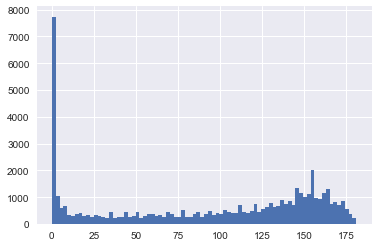

In [60]:
days_between_signup_and_last_trip.hist(bins=80)

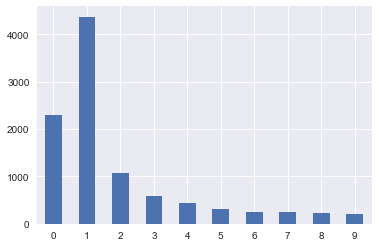

In [61]:
# address the peak for the groups of users only uses trip within a couple of days of sign up

days_between_signup_and_last_trip[days_between_signup_and_last_trip<10].value_counts().sort_index().plot.bar(rot=0);

In [62]:
# define the group of short-term user as using trips only within three days of signing up

print('%.1f percent of users only uses the trip within 3 days of signing up. These kind of users are defined to be short-term users.'%(100*len(user_retain[days_between_signup_and_last_trip<3])/len(user_retain)))

15.5 percent of users only uses the trip within 3 days of signing up. These kind of users are defined to be short-term users.


In [63]:
# get label
days_between_signup_and_last_trip
user_retain['retained']=days_between_signup_and_last_trip.apply(lambda x:'retained' if x>151 else 'short-term' if x<3 else 'other not retained')

In [64]:
user_retain.columns[user_retain.isnull().any()]

Index(['avg_rating_by_driver', 'avg_rating_of_driver', 'phone'], dtype='object')

In [65]:
user_retain.avg_rating_by_driver.fillna(user_retain.avg_rating_by_driver.mean(),inplace=True)
user_retain.avg_rating_of_driver.fillna(user_retain.avg_rating_of_driver.mean(),inplace=True)
user_retain.phone.fillna('Unknown',inplace=True)
user_retain.columns[user_retain.isnull().any()]

Index([], dtype='object')

In [66]:
for i in user_retain.columns:
    print(i,'\n', 'max', user_retain[i].max(),'\t', 'min',user_retain[i].min(),'\n####################')

avg_dist 
 max 160.96 	 min 0.0 
####################
avg_rating_by_driver 
 max 5.0 	 min 1.0 
####################
avg_rating_of_driver 
 max 5.0 	 min 1.0 
####################
avg_surge 
 max 8.0 	 min 1.0 
####################
city 
 max Winterfell 	 min Astapor 
####################
last_trip_date 
 max 2014-07-01 00:00:00 	 min 2014-01-01 00:00:00 
####################
phone 
 max iPhone 	 min Android 
####################
signup_date 
 max 2014-01-31 00:00:00 	 min 2014-01-01 00:00:00 
####################
surge_pct 
 max 100.0 	 min 0.0 
####################
trips_in_first_30_days 
 max 125 	 min 0 
####################
ultimate_black_user 
 max True 	 min False 
####################
weekday_pct 
 max 100.0 	 min 0.0 
####################
signup_weekday 
 max 6 	 min 0 
####################
retained 
 max short-term 	 min other not retained 
####################


In [67]:
user_retain[user_retain.avg_dist==0].head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,signup_weekday,retained
72,0.0,3.0,5.000000,1.0,Astapor,2014-01-08,iPhone,2014-01-07,0.0,1,False,100.0,1,short-term
116,0.0,5.0,5.000000,1.0,Winterfell,2014-01-11,Android,2014-01-10,0.0,1,False,100.0,4,short-term
188,0.0,5.0,4.601559,1.0,Winterfell,2014-01-14,Android,2014-01-11,0.0,1,False,100.0,5,other not retained
356,0.0,5.0,4.000000,1.0,Winterfell,2014-01-16,Android,2014-01-15,0.0,1,False,100.0,2,short-term
479,0.0,5.0,5.000000,1.0,Winterfell,2014-01-25,iPhone,2014-01-24,0.0,1,False,0.0,4,short-term


In [182]:
continous_val=['avg_dist', 'avg_rating_by_driver', 'avg_rating_of_driver', 'avg_surge','surge_pct',
       'trips_in_first_30_days','weekday_pct', 'signup_weekday','retained']

continous=user_retain[continous_val]

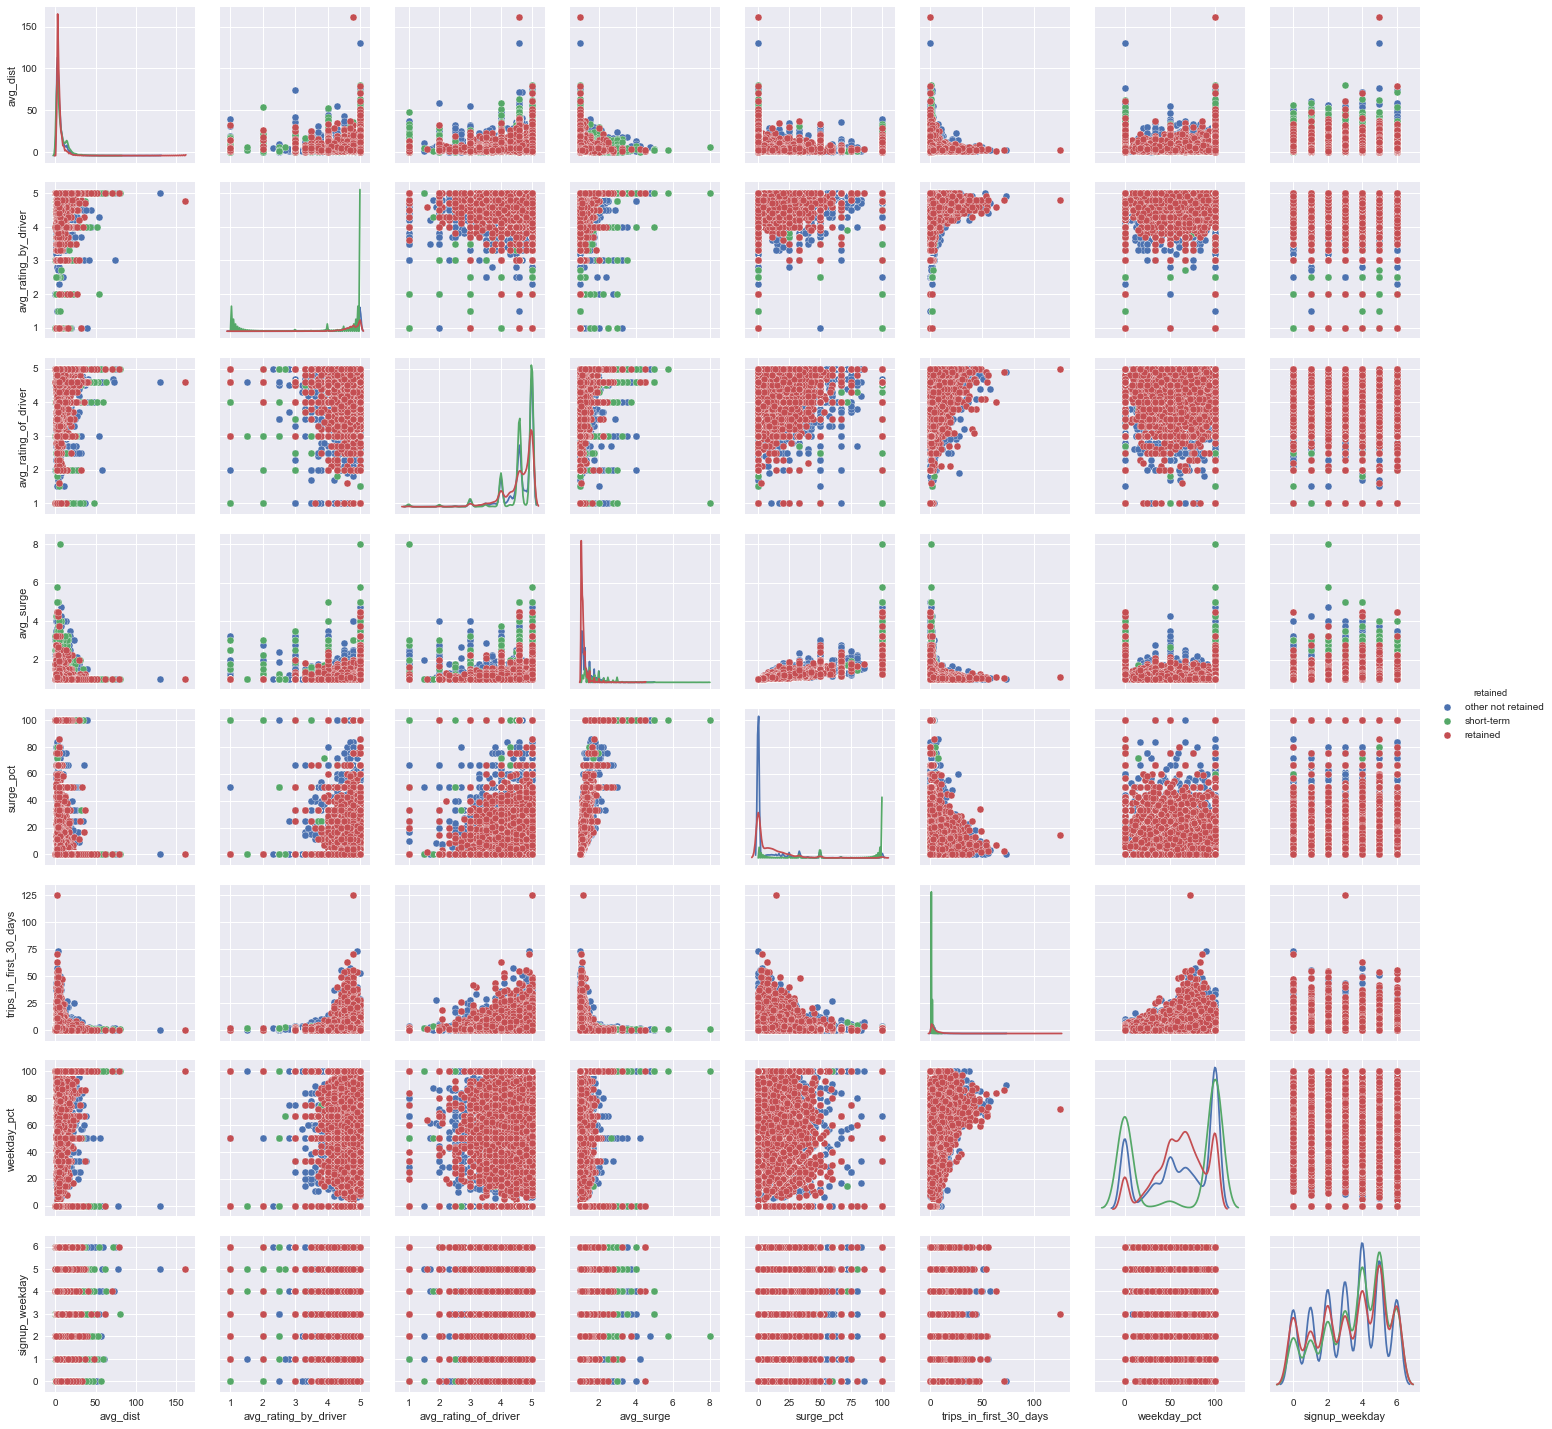

In [184]:
sns.pairplot(continous,hue='retained',diag_kind='kde') 
# in order to don't plot hue, have to make it catagorical. Maybe all catagorical columns are ignored in pairplot plotting

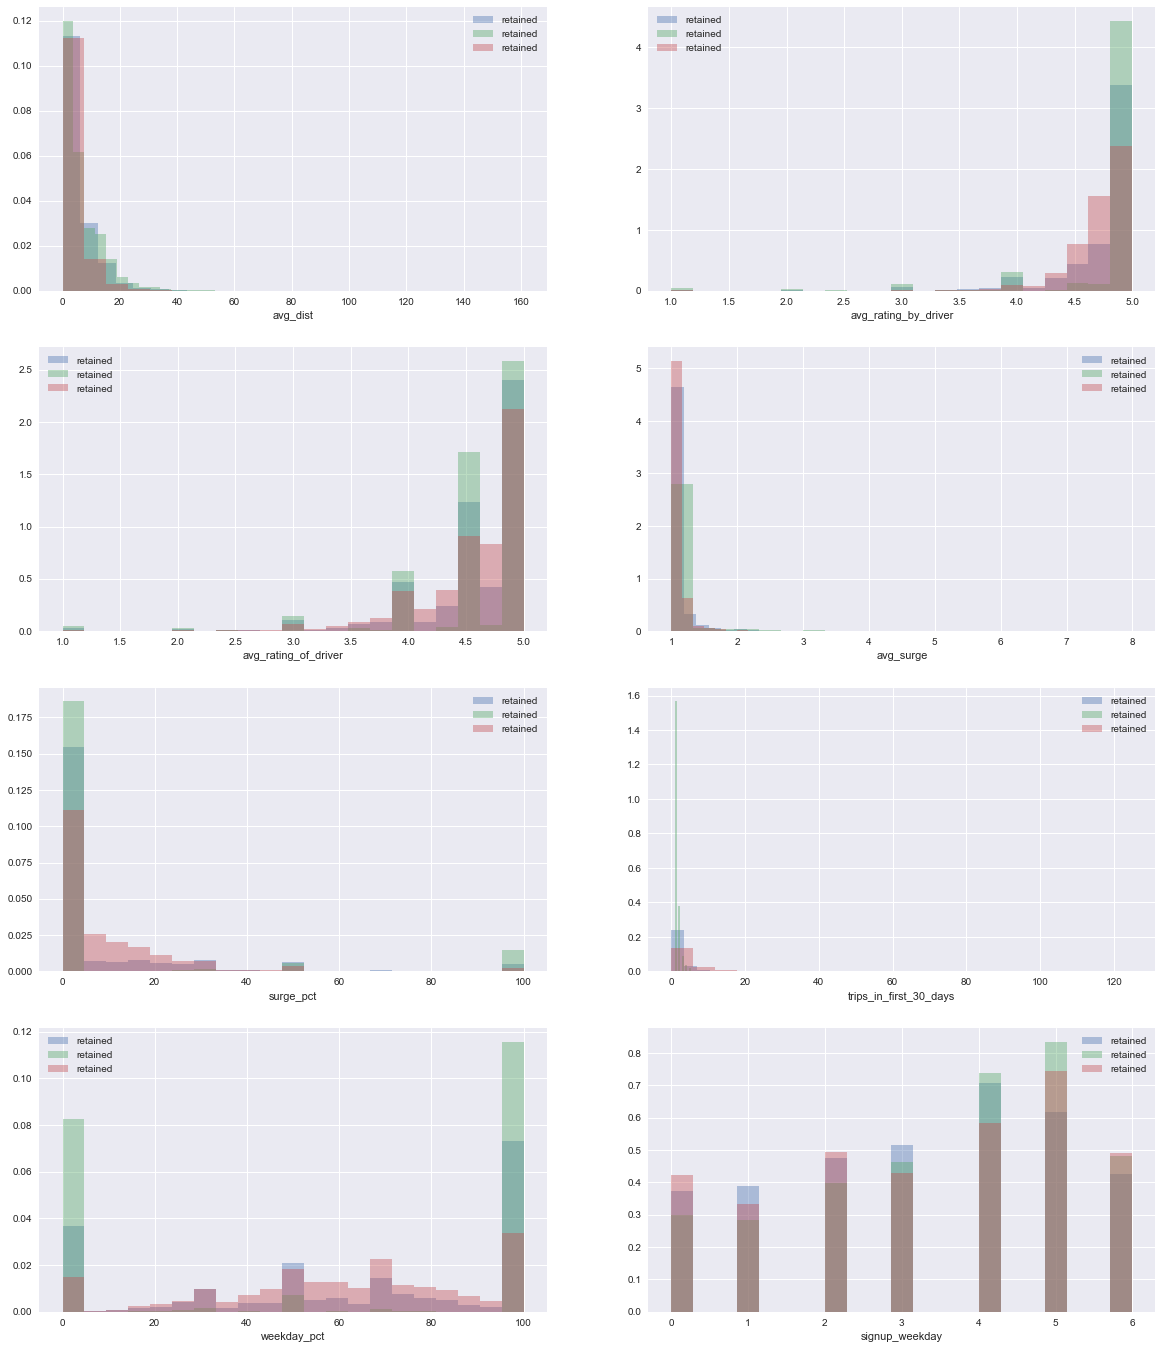

In [187]:
# Most information is contained in histograms, so take a closer look
plt.figure(figsize=(20,24))
for i in range(1,len(continous_val)):
    plt.subplot(4,2,i)
    col=continous_val[i-1]
    for n in user_retain.retained.unique():
        user_retain.loc[user_retain.retained==n,col].hist(label='retained',normed=True,alpha=0.4,bins=21)
   
    plt.legend()
    plt.gca().set_xlabel(col)
    i+=1
    

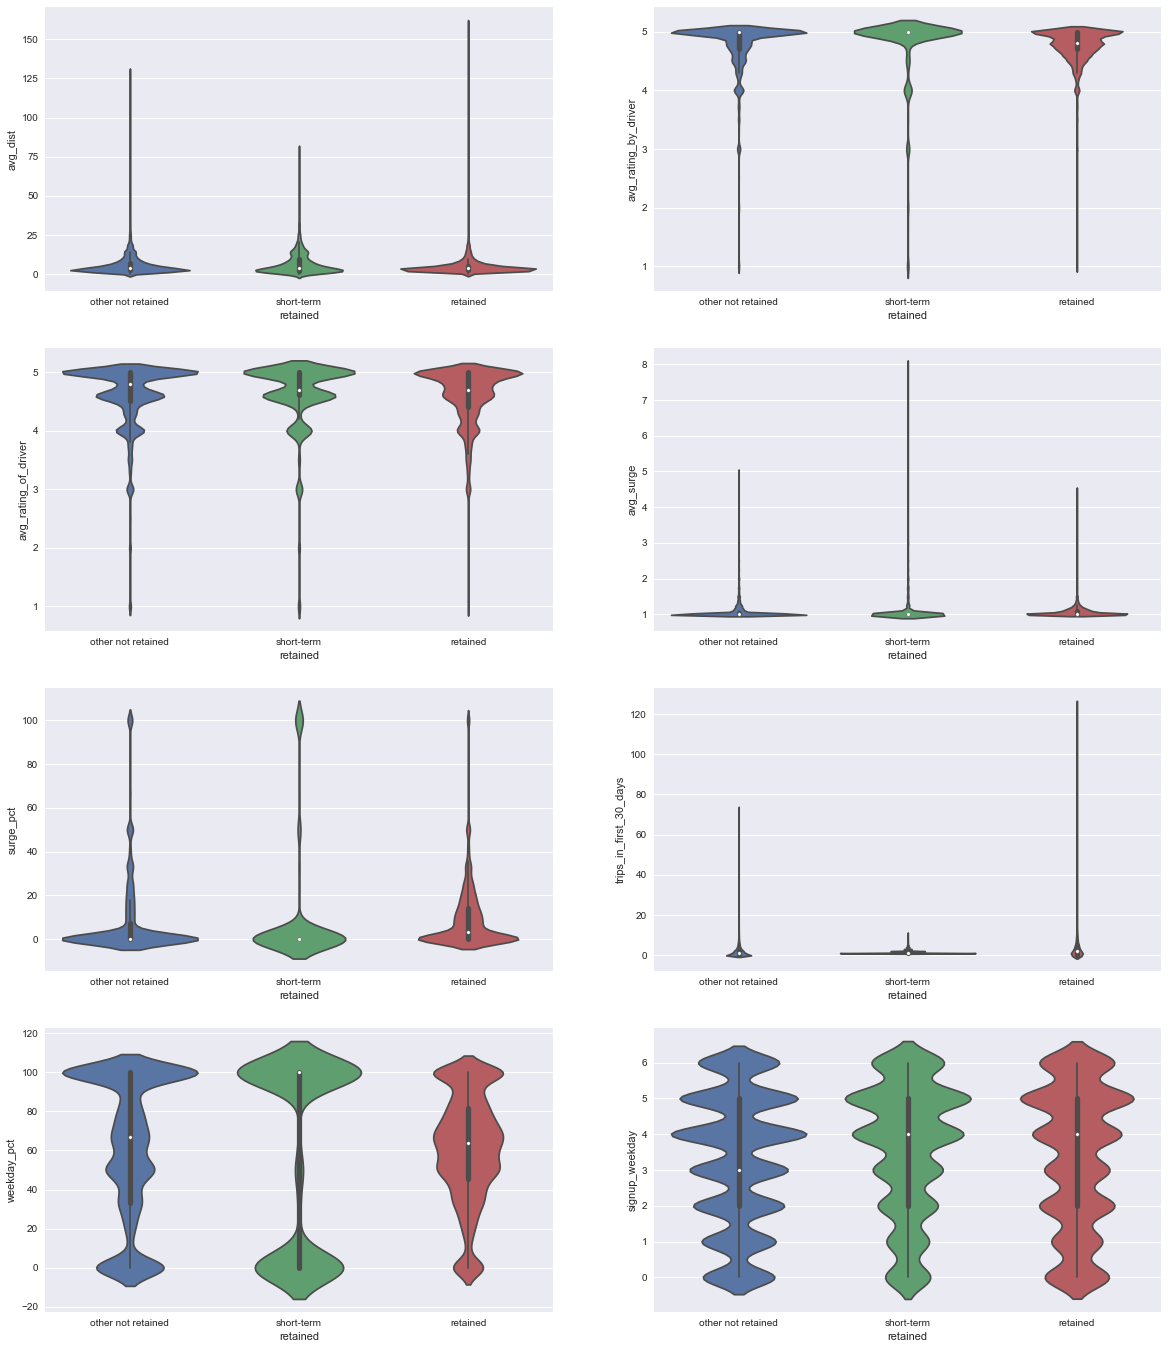

In [188]:
plt.figure(figsize=(20,24))
for i in range(1,len(continous_val)):
    plt.subplot(4,2,i)
    col=continous_val[i-1]
    
    sns.violinplot('retained', col, data=continous)
    i+=1

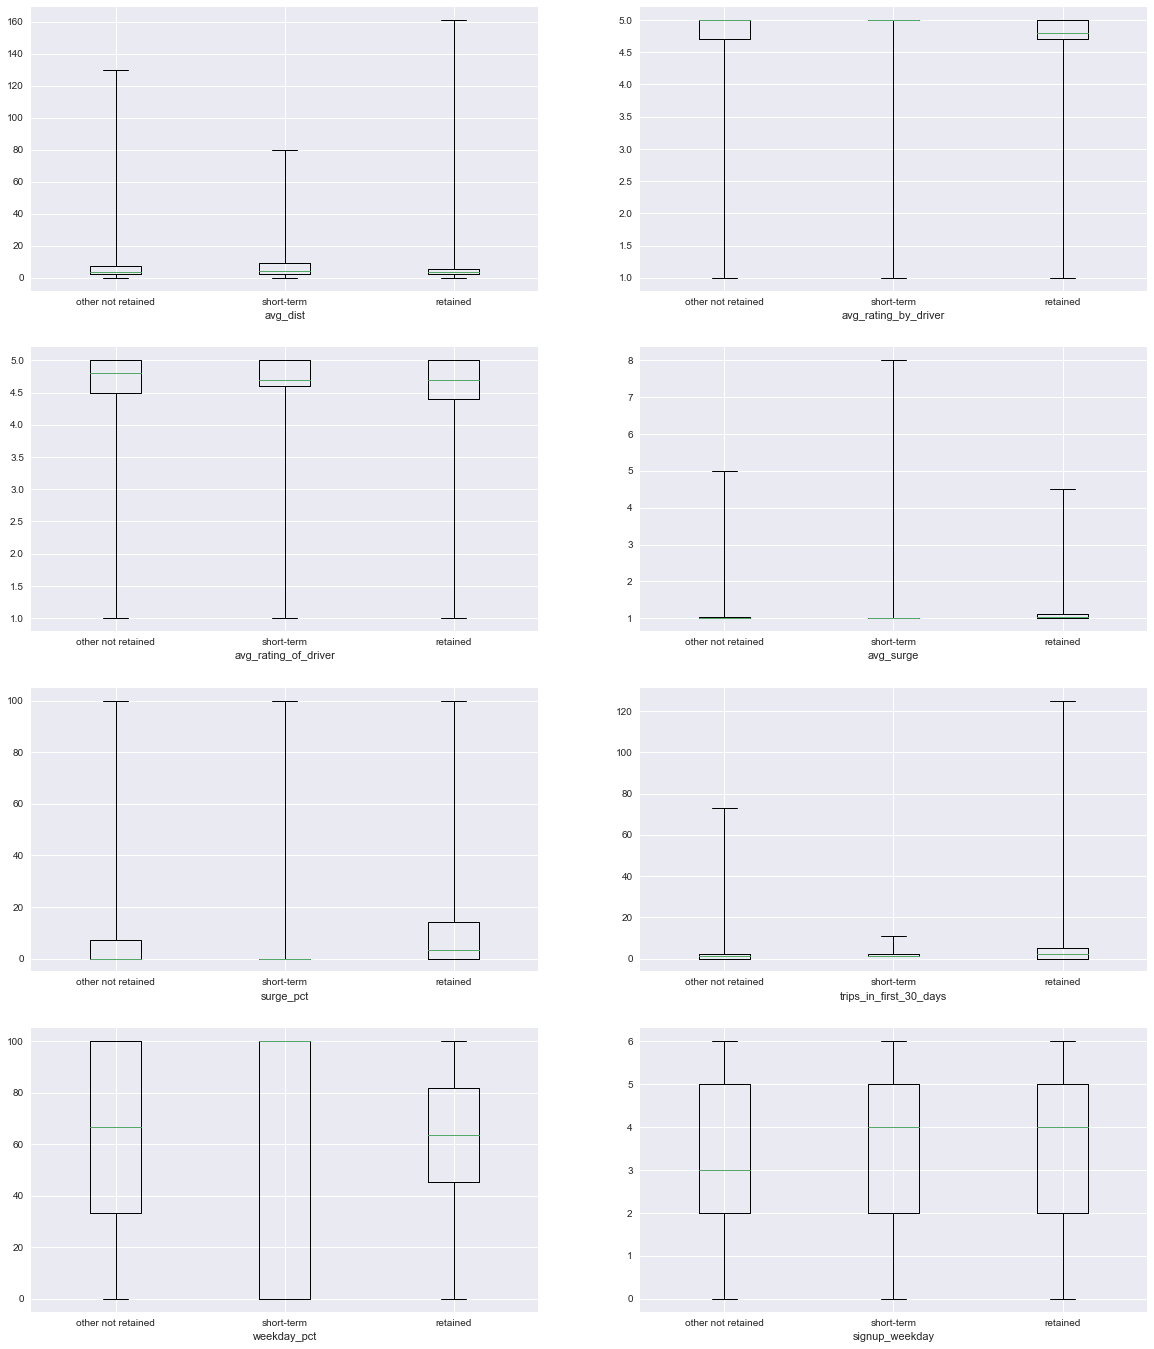

In [183]:
stt=continous.groupby('retained').agg(['mean','std'])
stt

plt.figure(figsize=(20,24))
for i in range(1,len(continous_val)):
    plt.subplot(4,2,i)
    col=continous_val[i-1]
    
    rt=user_retain.retained.unique()
    plt.boxplot([ continous.loc[continous.retained==rt[0],col], continous.loc[continous.retained==rt[1],col], continous.loc[continous.retained==rt[2],col] ], whis='range')
    plt.xticks([1,2,3],rt)
    plt.gca().set_xlabel(col)
    i+=1

A few obvious observatio from the graph above: 
* weekday_pct seems to have an obvious effect: retained users are more balanced distributed in weekday_pct, while other not retained users are skewed towards low and high ends of the distribution, meaning more likely to be either heavily use the trips on weekdays or weekends. This may be explained by that the not retained users on average have few trips to average from than users who are retained and likely to have booked more trips. For short-term users, this becomes especially obvious due to the reason that they only has very few trips to average from.  

* similarly, surge-pct,average-rating by driver and ave-rating of the driver also balanced for retained and clustered to two ends for not retained, likely due to the lack of averaging effect in not retained users as well

* the ratings doesn't seem to provide difference between whether a user would retain or not. Users all tend to provide high ratings for trips

* trips in first 30 days: retained users seems to have more trips in first 30 days on average

* ave-dist: retained users tend to have short distance on average, while not-retained users tend to have medium distance. I think this is an important feature. It can be intepreted that people book trips for once because they want to go to a not-so-short trip

In [189]:
np.setdiff1d(user_retain.columns.tolist(),continous_val)

array(['city', 'last_trip_date', 'phone', 'signup_date',
       'ultimate_black_user'], 
      dtype='<U22')

city 
 city                 Astapor  King's Landing  Winterfell
other not retained  0.361795        0.174829    0.463376
retained            0.219771        0.327860    0.452369
short-term          0.375371        0.123013    0.501615
################################
phone 
 phone                Android   Unknown    iPhone
other not retained  0.332221  0.007099  0.660680
retained            0.156918  0.006927  0.836155
short-term          0.391782  0.012663  0.595555
################################
ultimate_black_user 
 ultimate_black_user     False     True 
other not retained   0.652992  0.347008
retained             0.485206  0.514794
short-term           0.712237  0.287763
################################


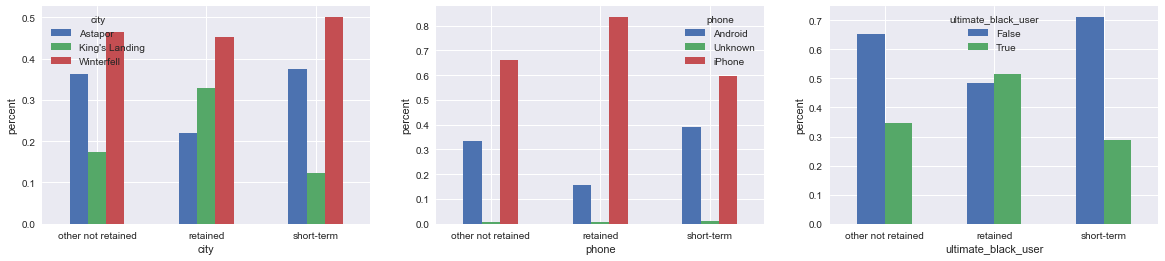

In [190]:
cat=['city', 'phone', 'ultimate_black_user']
total=pd.Series(user_retain.retained.value_counts(),index=user_retain.retained.unique())

df_list=[]
# catagorical to catagorical: percentage
for col in cat:
    df=pd.pivot_table(user_retain,index='retained',columns=col,values='signup_date',aggfunc='count').div(total,axis=0)
    df_list.append(df)

plt.figure(figsize=(20,4))    
i=1    
for name,df in zip(cat,df_list):
    print(name,'\n',df)   
    print('################################')
    ax=plt.subplot(1,3,i)
    i+=1
    df.plot.bar(rot=0,ax=ax)
    plt.gca().set_xlabel(name)
    plt.gca().set_ylabel('percent')
    

city: retained users have a higher percentage of going to King's Landing than the unretained users.
phone: retained users have higher percentage of using iphone than unretained
ultimate_black user: the percentage of ultimate black user is higher for retained users than unretained 

### modeling

In [134]:
# prepare data for modeling
def separate_label_features(df, labelcol):
    label=df[labelcol]
    features=df.drop(labelcol,axis=1)
    return features, label

def DictVectorizer_cat(df, cols):
    dv = DictVectorizer(sparse=False) 
    transformed=pd.DataFrame(dv.fit_transform(df[cols].to_dict( orient = 'records' )), columns=dv.feature_names_)
    return df.drop(cols,axis=1).join(transformed)


features, label=separate_label_features(user_retain, 'retained')

features.drop(['last_trip_date','signup_date'],axis=1,inplace=True)
features['ultimate_black_user']=features['ultimate_black_user'].astype(int)

cat=['city','phone']    
features=DictVectorizer_cat(features,cat)

# two ways of labeling: only label retained and not retained, label three classes
le = preprocessing.LabelEncoder()
label_3 = le.fit_transform(label)
classes_N=len(le.classes_)
print('label_3:',list(zip(le.classes_,le.transform(le.classes_))))
label_2=label=='retained'


# train test split
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(features, label_2, test_size=0.2, random_state=12)
X_train_3, X_test_3, y_train_3, y_test_3 = train_test_split(features, label_3, test_size=0.2, random_state=12)

label_3: [('other not retained', 0), ('retained', 1), ('short-term', 2)]


In [170]:
# model evaluation: accuracy
def scores(clf,X_train, X_test, y_train, y_test):
    pred_train=clf.predict(X_train)
    pred_test=clf.predict(X_test)

    acc_train= metrics.accuracy_score(y_train, pred_train)
    log_loss_train=metrics.log_loss(y_train, clf.predict_proba(X_train))

    acc_test= metrics.accuracy_score(y_test, pred_test)
    log_loss_test=metrics.log_loss(y_test, clf.predict_proba(X_test))

    print('train\n','accuracy\t',acc_train,'\n','log_loss\t',log_loss_train)
    print('test\n','accuracy\t',acc_test,'\n','log_loss\t',log_loss_test)
    
def test_scores(clf,X_test, y_test):

    pred_test=clf.predict(X_test)

    acc_test= metrics.accuracy_score(y_test, pred_test)
    log_loss_test=metrics.log_loss(y_test, clf.predict_proba(X_test))

    print('test\n','accuracy\t',acc_test,'\n','log_loss\t',log_loss_test)

In [136]:
# random forest 
rf=RandomForestClassifier(n_estimators=200, max_depth=10, n_jobs=-1,random_state=12)
rf.fit(X_train_3,y_train_3)
scores(rf,X_train_3, X_test_3, y_train_3, y_test_3)
print('test confusion matrix:\n',metrics.confusion_matrix(y_test_3, rf.predict(X_test_3)))

train
 accuracy	 0.74075 
 log_loss	 0.582627537153
test
 accuracy	 0.7147 
 log_loss	 0.629125566245
test confusion matrix:
 [[5274  447  413]
 [1488  795   31]
 [ 473    1 1078]]


In [137]:
# compare with only catagory of two catagories 
rf=RandomForestClassifier(n_estimators=200, max_depth=10, n_jobs=-1,random_state=12)
rf.fit(X_train_2,y_train_2)
scores(rf,X_train_2, X_test_2, y_train_2, y_test_2)
print('test confusion matrix:\n',metrics.confusion_matrix(y_test_2, rf.predict(X_test_2)))

train
 accuracy	 0.82245 
 log_loss	 0.386566599844
test
 accuracy	 0.8044 
 log_loss	 0.422137168464
test confusion matrix:
 [[7230  456]
 [1500  814]]


In [149]:
ftimp=pd.Series(rf.feature_importances_,index=features.columns)
ftimp.sort_values(ascending=False)

avg_rating_by_driver      0.171922
surge_pct                 0.149879
avg_surge                 0.125990
weekday_pct               0.121825
trips_in_first_30_days    0.070136
avg_dist                  0.064360
city=King's Landing       0.062094
ultimate_black_user       0.045389
phone=Android             0.039048
avg_rating_of_driver      0.038614
phone=iPhone              0.038535
signup_weekday            0.030254
city=Astapor              0.027775
city=Winterfell           0.012734
phone=Unknown             0.001446
dtype: float64

In [142]:
xg=xgb.XGBClassifier(objective='multi:softmax', max_depth=6)
xg.fit(X_train_3, y_train_3)
scores(xg,X_train_3, X_test_3, y_train_3, y_test_3)
print('test confusion matrix:\n',metrics.confusion_matrix(y_test_3, xg.predict(X_test_3)))

train
 accuracy	 0.7504 
 log_loss	 0.544646116405
test
 accuracy	 0.7227 
 log_loss	 0.591808353117
test confusion matrix:
 [[5072  547  515]
 [1337  930   47]
 [ 326    1 1225]]


In [150]:
xg=xgb.XGBClassifier(objective='binary:logistic', max_depth=6)
xg.fit(X_train_2, y_train_2)
scores(xg,X_train_2, X_test_2, y_train_2, y_test_2)
print('test confusion matrix:\n',metrics.confusion_matrix(y_test_2, xg.predict(X_test_2)))

train
 accuracy	 0.8288 
 log_loss	 0.378425346269
test
 accuracy	 0.808 
 log_loss	 0.413166954578
test confusion matrix:
 [[7131  555]
 [1365  949]]


In [151]:
xg=xgb.XGBClassifier(objective='binary:logistic', max_depth=8)
xg.fit(X_train_2, y_train_2)
scores(xg,X_train_2, X_test_2, y_train_2, y_test_2)
print('test confusion matrix:\n',metrics.confusion_matrix(y_test_2, xg.predict(X_test_2)))

train
 accuracy	 0.860525 
 log_loss	 0.331411354704
test
 accuracy	 0.8061 
 log_loss	 0.41724209673
test confusion matrix:
 [[7089  597]
 [1342  972]]


In [165]:
xg=xgb.XGBClassifier(objective='binary:logistic', max_depth=6, n_estimators=200)
xg.fit(X_train_2, y_train_2)
scores(xg,X_train_2, X_test_2, y_train_2, y_test_2)
print('test confusion matrix:\n',metrics.confusion_matrix(y_test_2, xg.predict(X_test_2)))

train
 accuracy	 0.845625 
 log_loss	 0.354223948166
test
 accuracy	 0.8071 
 log_loss	 0.413689177479
test confusion matrix:
 [[7108  578]
 [1351  963]]


In [166]:
def search_model(x_train, y_train, est, param_grid, cv, scorer=None):
    model = GridSearchCV(estimator  = est,
                         param_grid = param_grid,
                         cv      = cv,
                         scoring    = scorer)
    model.fit(x_train, y_train)
    print("Best score: %0.3f" % model.best_score_)
    print("Best parameters set:", model.best_params_)  
    print ('cv_results_:', model.cv_results_)
    return model

In [177]:
# cross validation
xg_params = {'max_depth':[4,5,6,7]} 
xg=xgb.XGBClassifier(objective='binary:logistic', n_estimators=200)
%time xg_cv1 = search_model(X_train_2, y_train_2,xg,xg_params,3,'accuracy')

Best score: 0.803
Best parameters set: {'max_depth': 4}
cv_results_: {'split1_test_score': array([ 0.80140993,  0.80110994,  0.80140993,  0.79773511]), 'split2_train_score': array([ 0.82289636,  0.83639568,  0.85653217,  0.87839358]), 'param_max_depth': masked_array(data = [4 5 6 7],
             mask = [False False False False],
       fill_value = ?)
, 'std_train_score': array([ 0.00097193,  0.00031155,  0.00193937,  0.00302428]), 'rank_test_score': array([1, 2, 3, 4]), 'split0_test_score': array([ 0.80470976,  0.80365982,  0.80223489,  0.80313484]), 'std_fit_time': array([ 0.07552819,  0.18252418,  0.18006479,  0.234435  ]), 'params': ({'max_depth': 4}, {'max_depth': 5}, {'max_depth': 6}, {'max_depth': 7}), 'std_score_time': array([ 0.00030925,  0.02431233,  0.00667405,  0.00736637]), 'mean_fit_time': array([ 2.88806923,  3.87583447,  4.17314736,  4.90465919]), 'split2_test_score': array([ 0.80408041,  0.80445545,  0.80175518,  0.79845485]), 'std_test_score': array([ 0.00143051,  0.

In [180]:
bes=xg_cv1.best_estimator_.fit(X_train_2, y_train_2)
test_scores(bes,X_test_2, y_test_2)

test
 accuracy	 0.8083 
 log_loss	 0.41175416169


I tried random forest and xgboost, xgboost is a more advanced tree model. Through grid search, the best test score I get for accuracy is 0.808. Below is the importance rank of the features.Seems ave_dist is the most important feature.

In [174]:
ftimp=pd.Series(xg_cv1.best_estimator_.feature_importances_,index=features.columns)
ftimp.sort_values(ascending=False)

avg_dist                  0.202856
weekday_pct               0.131462
trips_in_first_30_days    0.125554
surge_pct                 0.103890
avg_surge                 0.085180
avg_rating_by_driver      0.077302
signup_weekday            0.072378
avg_rating_of_driver      0.068932
city=King's Landing       0.040374
ultimate_black_user       0.027573
city=Astapor              0.025111
phone=iPhone              0.018218
phone=Android             0.014771
city=Winterfell           0.005416
phone=Unknown             0.000985
dtype: float32

ave_dist: based on the graph before, ave_dist tends to be short distance for retained users. Therefore, it is important to advertise more on short trips, and also increase short trips quality. 
Similarly, put more emphasis on King's trip, iphone, and ultimate_black_user feature in business quality could help attract more retained users. 